# ANALITICA DE DATOS CON INTELIGENCIA ARTIFICIAL

# EDA con datos EPM

**Universidad de los Andes**

2024

---

ERIKA JULIETH JIMENEZ LOPEZ ERIKA.JIMENEZ@epm.com.co EIDY NORELLY CARVAJAL BEDOYA EIDY.CARVAJAL@epm.com.co BIBIANA CRISTINA RODAS GALLEGO BIBIANA.RODAS@epm.com.co WILSON DARIO GRACIANO BRAVO Wilson.Graciano@epm.com.co JOHN ALEJANDRO COLORADO HENAO JOHN.COLORADO@epm.com.co CARLOS IVAN URIBE CAMARGO CARLOS.URIBE@epm.com.co

# PREDICCION DE ENSA A PARTIR DE DEEP LEARNING para EL MES DE MAYO

**Necesidad:** modelar la relación existente entre el registro de temperatura de las instalaciones (puntos de servicio) del Área Metropolitana de Medellín de acuerdo con tomas de drones termográficos (por realizar) y el consumo de energía de las instalaciones, así como el registro histórico de defraudaciones de dicho servicio (fraudes).

In [1]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Montar Google Drive (asumiendo que los datos están allí)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Cargar los datos
#file_path = '/content/drive/MyDrive/DIPLOMADO EPM/Datos/BD_maestro.csv'  # Ajusta a la ubicación de tu archivo CSV
file_path = '/content/BD_maestro.csv'
datos_Maestro = pd.read_csv(file_path)

In [4]:
# Convertir la columna 'fecha' a datetime
datos_Maestro['fecha'] = pd.to_datetime(datos_Maestro['fecha'])

In [5]:
datos_Maestro.describe()

,fecha,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,ENSA,dummy
count,168,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.0
mean,2016-12-15 16:17:08.571428608,-0.042262,41.325214,0.056429,55.482143,0.085714,71.732143,3.432738,806.142857,283.601190,0.0
min,2010-01-01 00:00:00,-1.700000,25.066000,-0.180000,29.440000,-0.180000,17.000000,1.600000,529.000000,195.000000,0.0
25%,2013-06-23 12:00:00,-0.700000,32.745000,0.050000,45.600000,0.070000,52.000000,2.600000,706.750000,254.750000,0.0
50%,2016-12-16 12:00:00,-0.200000,37.277000,0.060000,55.964000,0.090000,72.000000,3.000000,827.500000,289.000000,0.0
75%,2020-06-08 12:00:00,0.500000,41.799000,0.100000,64.929000,0.140000,89.750000,4.100000,894.000000,312.000000,0.0
max,2023-12-01 00:00:00,2.600000,78.591000,0.160000,76.523000,0.180000,115.000000,8.800000,1067.000000,361.000000,0.0
std,NaN,0.903917,15.107150,0.073764,13.913906,0.087003,22.023252,1.273004,123.033382,38.216393,0.0


In [6]:
datos_Maestro['fecha'] = pd.to_datetime(datos_Maestro['fecha'], format='%Y-%m-%d %H:%M:%S')

In [7]:
datos_Maestro.describe()

,fecha,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,ENSA,dummy
count,168,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.0
mean,2016-12-15 16:17:08.571428608,-0.042262,41.325214,0.056429,55.482143,0.085714,71.732143,3.432738,806.142857,283.601190,0.0
min,2010-01-01 00:00:00,-1.700000,25.066000,-0.180000,29.440000,-0.180000,17.000000,1.600000,529.000000,195.000000,0.0
25%,2013-06-23 12:00:00,-0.700000,32.745000,0.050000,45.600000,0.070000,52.000000,2.600000,706.750000,254.750000,0.0
50%,2016-12-16 12:00:00,-0.200000,37.277000,0.060000,55.964000,0.090000,72.000000,3.000000,827.500000,289.000000,0.0
75%,2020-06-08 12:00:00,0.500000,41.799000,0.100000,64.929000,0.140000,89.750000,4.100000,894.000000,312.000000,0.0
max,2023-12-01 00:00:00,2.600000,78.591000,0.160000,76.523000,0.180000,115.000000,8.800000,1067.000000,361.000000,0.0
std,NaN,0.903917,15.107150,0.073764,13.913906,0.087003,22.023252,1.273004,123.033382,38.216393,0.0


In [8]:
# Encontrar NaNs y valores duplicados en datos_Maestro

print('hay {} valores missing o NaNs en datos_Maestro.'
      .format(datos_Maestro.isnull().values.sum()))

temp_datos = datos_Maestro.duplicated(keep='first').sum()

print('hay {} filas duplicadas en datos_Maestro revisando todas las columnas.'
      .format(temp_datos))

hay 0 valores missing o NaNs en datos_Maestro.
hay 0 filas duplicadas en datos_Maestro revisando todas las columnas.


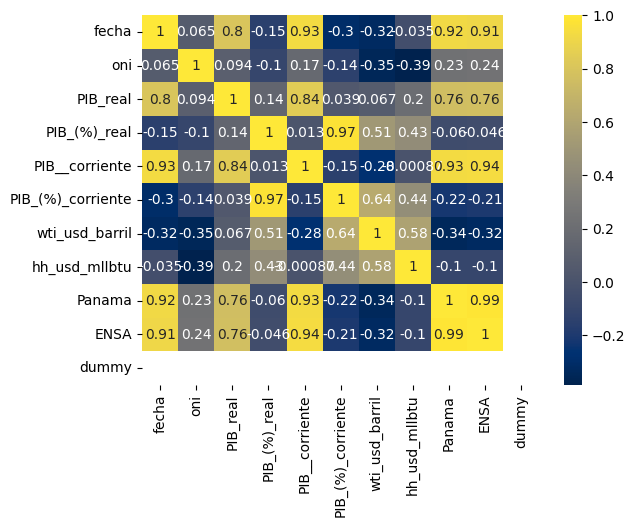

In [9]:
# EDA básico: matriz de correlación y gráficas
sns.heatmap(datos_Maestro.corr(), annot=True, cmap='cividis')
plt.show()

In [10]:
correlations = datos_Maestro.corr(method='pearson')
print(correlations['ENSA'].sort_values(ascending=False).to_string())

ENSA                 1.000000
Panama               0.986787
PIB__corriente       0.939072
fecha                0.909834
PIB_real             0.764443
oni                  0.239502
PIB_(%)_real        -0.045753
hh_usd_mllbtu       -0.103195
PIB_(%)_corriente   -0.206166
wti_usd_barril      -0.324960
dummy                     NaN


In [11]:
datos_Maestro.dtypes

fecha                datetime64[ns]
oni                         float64
PIB_real                    float64
PIB_(%)_real                float64
PIB__corriente              float64
PIB_(%)_corriente           float64
wti_usd_barril                int64
hh_usd_mllbtu               float64
Panama                        int64
ENSA                          int64
dummy                         int64
dtype: object

In [12]:
# Definir una funcion para graficar los diferentes tipos de time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):

    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

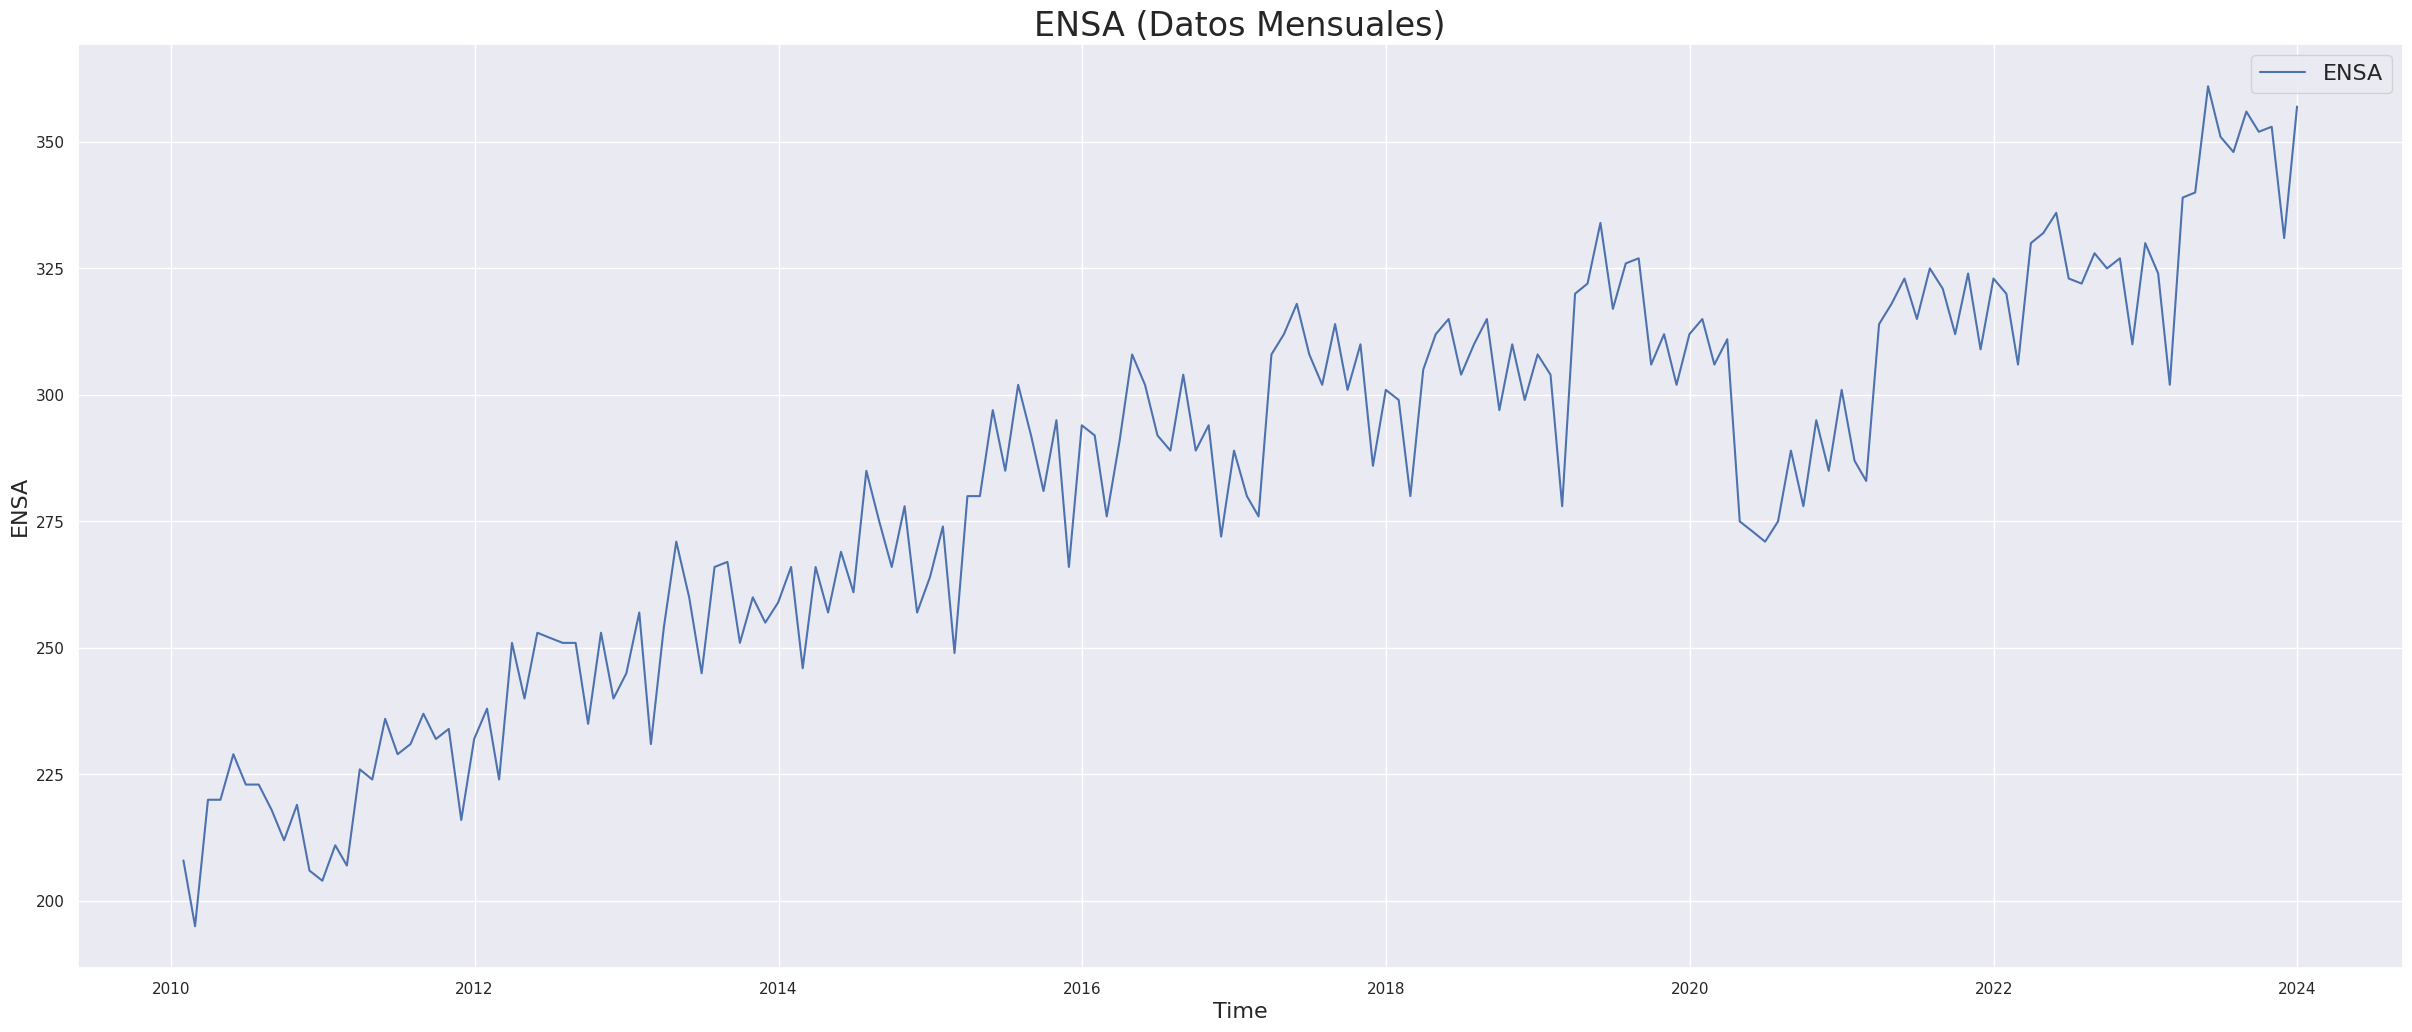

In [13]:
#ax = plot_series(df=datos_Maestro, column='ENSA', ylabel='ENSA(xxx)',
#                 title='ENSA actual (Primeras 2 semanas - Original)', end=24*7*2)
#plt.show()

#ax = plot_series(df=datos_Maestro, column='ENSA', ylabel='ENSA(xxx)',
#                 title='ENSA actual')
#plt.show()

monthly_data = datos_Maestro.groupby(pd.Grouper(key='fecha', freq='M')).sum()

ax = plot_series(df=monthly_data, column='ENSA', label='ENSA', ylabel='ENSA',
                 title='ENSA (Datos Mensuales)', end=None)
plt.show()


In [14]:
# Borrar columnas con informacion metereologica cualitativa
datos_Maestro = datos_Maestro.drop(['dummy'], axis=1)

In [15]:
datos_Maestro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha              168 non-null    datetime64[ns]
 1   oni                168 non-null    float64       
 2   PIB_real           168 non-null    float64       
 3   PIB_(%)_real       168 non-null    float64       
 4   PIB__corriente     168 non-null    float64       
 5   PIB_(%)_corriente  168 non-null    float64       
 6   wti_usd_barril     168 non-null    int64         
 7   hh_usd_mllbtu      168 non-null    float64       
 8   Panama             168 non-null    int64         
 9   ENSA               168 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 13.2 KB


In [16]:
# Adicionar las columnas 'Panama_PIB_suma' y 'Ratio_ENSA_PIB_real'
datos_Maestro['Panama_PIB_suma'] = datos_Maestro['Panama'] + datos_Maestro['PIB__corriente']
# capturará la relación relativa entre el consumo de energía (ENSA) y el Producto Interno Bruto real (PIB_real), lo cual puede ser útil para entender cómo
#varía el consumo de energía en relación con la actividad económica real
datos_Maestro['Ratio_ENSA_PIB_real'] = datos_Maestro['ENSA'] / datos_Maestro['PIB_real']

# Reorganizar las columnas para mover 'ENSA' al final del DataFrame
column_order = ['fecha', 'oni', 'PIB_real', 'PIB_(%)_real', 'PIB__corriente', 'PIB_(%)_corriente', 'wti_usd_barril', 'hh_usd_mllbtu', 'Panama', 'Panama_PIB_suma', 'Ratio_ENSA_PIB_real', 'ENSA']
datos_Maestro = datos_Maestro[column_order]


In [17]:
datos_Maestro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   fecha                168 non-null    datetime64[ns]
 1   oni                  168 non-null    float64       
 2   PIB_real             168 non-null    float64       
 3   PIB_(%)_real         168 non-null    float64       
 4   PIB__corriente       168 non-null    float64       
 5   PIB_(%)_corriente    168 non-null    float64       
 6   wti_usd_barril       168 non-null    int64         
 7   hh_usd_mllbtu        168 non-null    float64       
 8   Panama               168 non-null    int64         
 9   Panama_PIB_suma      168 non-null    float64       
 10  Ratio_ENSA_PIB_real  168 non-null    float64       
 11  ENSA                 168 non-null    int64         
dtypes: datetime64[ns](1), float64(8), int64(3)
memory usage: 15.9 KB


In [20]:
# Estandarización de los datos

# Seleccionar solo columnas numéricas
datos_numericos = datos_Maestro.select_dtypes(include=[np.number])

# Estandarización de los datos numéricos
scaler = StandardScaler()
datos_escalados = scaler.fit_transform(datos_numericos)
datos_escalados = pd.DataFrame(datos_escalados, columns=datos_numericos.columns)

# Añadir de nuevo las columnas no numéricas al DataFrame escalado
for col in datos_Maestro.select_dtypes(exclude=[np.number]).columns:
    datos_escalados[col] = datos_Maestro[col]


In [21]:
datos_escalados_fecha =  datos_escalados.sort_values(by='fecha').copy()
datos_escalados_fecha = datos_escalados_fecha.set_index('fecha').copy()
datos_escalados_fecha

,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,Panama_PIB_suma,Ratio_ENSA_PIB_real,ENSA
fecha,,,,,,,,,,,
2010-01-01,1.711300,-1.079477,0.048562,-1.877258,0.049407,0.285453,1.865147,-1.933230,-1.939218,0.775355,-1.984154
2010-02-01,1.489379,-1.079477,0.048562,-1.877258,0.049407,0.194368,1.471201,-2.259317,-2.233948,0.369170,-2.325339
2010-03-01,1.045537,-1.079477,0.048562,-1.877258,0.049407,0.422080,0.683309,-1.484860,-1.533963,1.150295,-1.669214
2010-04-01,0.490736,-1.079477,0.048562,-1.877258,0.049407,0.558706,0.446941,-1.664208,-1.696065,1.150295,-1.669214
2010-05-01,-0.064066,-1.079477,0.048562,-1.877258,0.049407,0.103283,0.525730,-1.484860,-1.533963,1.431499,-1.433009
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,1.489379,2.474139,0.184536,1.516739,0.049407,0.422080,-0.656108,1.857531,1.833947,-2.175938,1.900107
2023-09-01,1.822260,2.474139,0.184536,1.516739,0.049407,0.786418,-0.656108,1.564053,1.568690,-2.215799,1.795127
2023-10-01,2.044181,2.474139,0.184536,1.516739,0.049407,0.649791,-0.340951,1.824922,1.804474,-2.205834,1.821372


In [22]:
datos_escalados_fecha.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2010-01-01 to 2023-12-01
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oni                  168 non-null    float64
 1   PIB_real             168 non-null    float64
 2   PIB_(%)_real         168 non-null    float64
 3   PIB__corriente       168 non-null    float64
 4   PIB_(%)_corriente    168 non-null    float64
 5   wti_usd_barril       168 non-null    float64
 6   hh_usd_mllbtu        168 non-null    float64
 7   Panama               168 non-null    float64
 8   Panama_PIB_suma      168 non-null    float64
 9   Ratio_ENSA_PIB_real  168 non-null    float64
 10  ENSA                 168 non-null    float64
dtypes: float64(11)
memory usage: 15.8 KB


In [23]:
datos_escalados_fecha.head()

,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,Panama_PIB_suma,Ratio_ENSA_PIB_real,ENSA
fecha,,,,,,,,,,,
2010-01-01,1.711300,-1.079477,0.048562,-1.877258,0.049407,0.285453,1.865147,-1.933230,-1.939218,0.775355,-1.984154
2010-02-01,1.489379,-1.079477,0.048562,-1.877258,0.049407,0.194368,1.471201,-2.259317,-2.233948,0.369170,-2.325339
2010-03-01,1.045537,-1.079477,0.048562,-1.877258,0.049407,0.422080,0.683309,-1.484860,-1.533963,1.150295,-1.669214
2010-04-01,0.490736,-1.079477,0.048562,-1.877258,0.049407,0.558706,0.446941,-1.664208,-1.696065,1.150295,-1.669214
2010-05-01,-0.064066,-1.079477,0.048562,-1.877258,0.049407,0.103283,0.525730,-1.484860,-1.533963,1.431499,-1.433009


In [24]:
datos_escalados_fecha.head()

,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,Panama_PIB_suma,Ratio_ENSA_PIB_real,ENSA
fecha,,,,,,,,,,,
2010-01-01,1.711300,-1.079477,0.048562,-1.877258,0.049407,0.285453,1.865147,-1.933230,-1.939218,0.775355,-1.984154
2010-02-01,1.489379,-1.079477,0.048562,-1.877258,0.049407,0.194368,1.471201,-2.259317,-2.233948,0.369170,-2.325339
2010-03-01,1.045537,-1.079477,0.048562,-1.877258,0.049407,0.422080,0.683309,-1.484860,-1.533963,1.150295,-1.669214
2010-04-01,0.490736,-1.079477,0.048562,-1.877258,0.049407,0.558706,0.446941,-1.664208,-1.696065,1.150295,-1.669214
2010-05-01,-0.064066,-1.079477,0.048562,-1.877258,0.049407,0.103283,0.525730,-1.484860,-1.533963,1.431499,-1.433009


In [34]:
# Preparar datos para LSTM
window_size = 12 #24
X = []
y = []
#X = datos_escalados_fecha.drop(columns=['ENSA']).values
#y = datos_escalados_fecha['ENSA'].values


for i in range(window_size, len(datos_escalados_fecha) - 12):  # -12 para predecir el año completo de 2024
    X.append(datos_escalados_fecha.iloc[i-window_size:i, :-1].values)  # Todas las variables excepto ENSA
    y.append(datos_escalados_fecha.iloc[i, -1])  # La variable ENSA

X, y = np.array(X), np.array(y)



In [26]:
# División en entrenamiento y validación
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


In [27]:
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)


Forma de X_train: (115, 12, 10)
Forma de y_train: (115,)
Forma de X: (144, 12, 10)
Forma de y: (144,)


In [28]:
# Definir la arquitectura LSTM
model = Sequential([
    InputLayer((window_size, datos_numericos.shape[1] - 1)),
    LSTM(131, activation='relu'),
    Dense(151, activation='tanh'),
    Dense(1, activation='linear')
])

In [ ]:
# Definir la arquitectura GRU
#model = Sequential([
    #InputLayer(input_shape=(window_size, datos_numericos.shape[1] - 1)),
    #GRU(50, activation='relu', return_sequences=True),
    #GRU(50, activation='relu'),
    #Dense(20, activation='relu'),
    #Dense(1)
#])

In [29]:
# Compilar y entrenar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/100
4/4 [==============================] - 2s 142ms/step - loss: 0.4147 - val_loss: 0.8080
Epoch 2/100
4/4 [==============================] - 0s 51ms/step - loss: 0.1989 - val_loss: 0.2782
Epoch 3/100
4/4 [==============================] - 0s 45ms/step - loss: 0.1150 - val_loss: 0.2172
Epoch 4/100
4/4 [==============================] - 0s 43ms/step - loss: 0.0974 - val_loss: 0.4793
Epoch 5/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0969 - val_loss: 0.7714
Epoch 6/100
4/4 [==============================] - 0s 48ms/step - loss: 0.0824 - val_loss: 0.8784
Epoch 7/100
4/4 [==============================] - 0s 43ms/step - loss: 0.0790 - val_loss: 0.7188
Epoch 8/100
4/4 [==============================] - 0s 49ms/step - loss: 0.0733 - val_loss: 0.5721
Epoch 9/100
4/4 [==============================] - 0s 46ms/step - loss: 0.0728 - val_loss: 0.4866
Epoch 10/100
4/4 [==============================] - 0s 44ms/step - loss: 0.0716 - val_loss: 0.5053
Epoch 11/100
4/4 [

In [ ]:
# Generar predicciones para 2024 (esto requiere datos futuros que podríamos simular o extender en base a los últimos datos disponibles)


# **Pasos a seguir**

**Generación de características futuras:** como el modelo depende de entradas que necesitamos prever (como las temperaturas futuras), necesitamos estimar o simular estos datos para 2024.

**Extensión del conjunto de datos:** Extendiendo los datos hasta junio de 2024, asumiendo ciertas tendencias o repitiendo patrones anteriores si no hay mejor estimación disponible.

**Predicción con el modelo:** Utilizar el modelo para hacer las predicciones basadas en estas entradas extendidas o simuladas.

In [30]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

In [31]:
# Simular datos futuros para las características necesarias basándonos en las últimas observaciones
periodos = 6

last_date = datos_Maestro['fecha'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periodos, freq='M')

In [32]:
future_dates

DatetimeIndex(['2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31'],
              dtype='datetime64[ns]', freq='M')

In [36]:
# Asumiendo que la tendencia de las características numéricas se mantiene constante
future_data = []
for date in future_dates:
    last_row = datos_numericos.iloc[-1].copy()
    last_row.name = date
    future_data.append(last_row)

future_df = pd.DataFrame(future_data)

In [44]:
# Concatenar los datos simulados con los datos originales
extended_data = pd.concat([datos_numericos, future_df])
extended_index_ultimos_6 = extended_data.tail(periodos).index
extended_data

,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,Panama_PIB_suma,Ratio_ENSA_PIB_real,ENSA
0,1.5,25.066,0.06,29.440,0.09,78.0,5.8,569.0,598.440,8.298093,208.0
1,1.3,25.066,0.06,29.440,0.09,76.0,5.3,529.0,558.440,7.779462,195.0
2,0.9,25.066,0.06,29.440,0.09,81.0,4.3,624.0,653.440,8.776829,220.0
3,0.4,25.066,0.06,29.440,0.09,84.0,4.0,602.0,631.440,8.776829,220.0
4,-0.1,25.066,0.06,29.440,0.09,74.0,4.1,624.0,653.440,9.135881,229.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 00:00:00,2.0,78.591,0.07,76.523,0.09,72.0,2.5,1043.0,1119.523,4.542505,357.0
2024-02-29 00:00:00,2.0,78.591,0.07,76.523,0.09,72.0,2.5,1043.0,1119.523,4.542505,357.0
2024-03-31 00:00:00,2.0,78.591,0.07,76.523,0.09,72.0,2.5,1043.0,1119.523,4.542505,357.0
2024-04-30 00:00:00,2.0,78.591,0.07,76.523,0.09,72.0,2.5,1043.0,1119.523,4.542505,357.0


In [88]:
# Escalar los datos extendidos
extended_scaled = scaler.transform(extended_data)
extended_scaled = pd.DataFrame(extended_scaled, columns=extended_data.columns)


In [89]:
extended_scaled

,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,Panama_PIB_suma,Ratio_ENSA_PIB_real,ENSA
0,1.711300,-1.079477,0.048562,-1.877258,0.049407,0.285453,1.865147,-1.933230,-1.939218,0.775355,-1.984154
1,1.489379,-1.079477,0.048562,-1.877258,0.049407,0.194368,1.471201,-2.259317,-2.233948,0.369170,-2.325339
2,1.045537,-1.079477,0.048562,-1.877258,0.049407,0.422080,0.683309,-1.484860,-1.533963,1.150295,-1.669214
3,0.490736,-1.079477,0.048562,-1.877258,0.049407,0.558706,0.446941,-1.664208,-1.696065,1.150295,-1.669214
4,-0.064066,-1.079477,0.048562,-1.877258,0.049407,0.103283,0.525730,-1.484860,-1.533963,1.431499,-1.433009
...,...,...,...,...,...,...,...,...,...,...,...
169,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,1.900262,-2.165972,1.926352
170,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,1.900262,-2.165972,1.926352
171,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,1.900262,-2.165972,1.926352
172,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,1.900262,-2.165972,1.926352


In [47]:
# Preparar datos para LSTM incluyendo los futuros
X_extended = []
y_extended = []

for i in range(window_size, len(extended_scaled) - periodos):  # Preparar hasta junio de 2024
    X_extended.append(extended_scaled.iloc[i-window_size:i, :-1].values)  # Excluir ENSA
    y_extended.append(extended_scaled.iloc[i, -1])  # Incluir ENSA

X_extended = np.array(X_extended)
y_extended = np.array(y_extended)

In [48]:
# Predicciones para los primeros 6 meses de 2024
predictions = model.predict(X_extended[-6:])  # Últimos 6 registros para predicción

1/1 [==============================] - 0s 218ms/step


In [90]:
# Mostrar las predicciones
print("Predicciones de ENSA para los primeros 6 meses de 2024:")
print(predictions.flatten())


Predicciones de ENSA para los primeros 6 meses de 2024:
[10.20553    9.3742485  7.8933287  7.032486   5.7472873  5.80706  ]


**Supongamos que 'predictions' es el array obtenido de las predicciones anteriores**
**y 'future_dates' contiene las fechas correspondientes a estas predicciones**

In [84]:
# Crear un DataFrame para las predicciones
predictions_df = pd.DataFrame({
    'fecha': future_dates,
    'ENSA_pred': predictions.flatten()
})

In [85]:
# Filtrar los datos desde 2022 para visualizar
historical_data = datos_Maestro[(datos_Maestro['fecha'] >= '2022-01-01') & (datos_Maestro['fecha'] <= last_date)]
historical_data = historical_data[['fecha', 'ENSA']]

In [86]:
# Combinar los datos históricos con las predicciones
combined_data = pd.concat([historical_data, predictions_df])

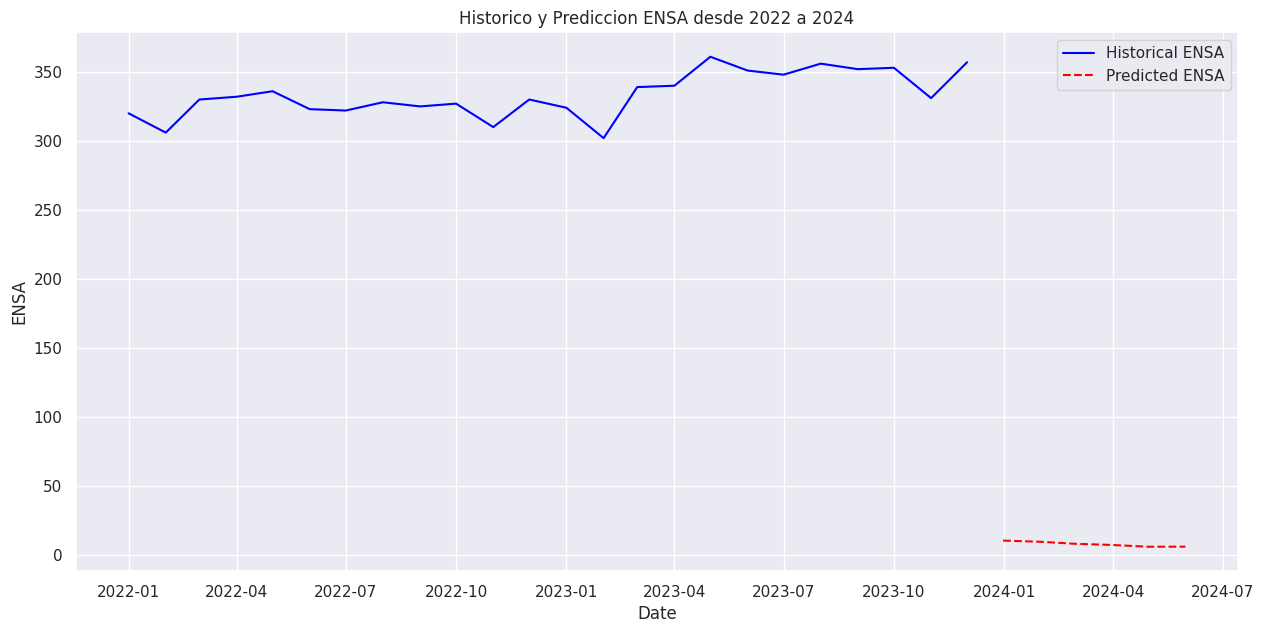

In [87]:
# Graficar los resultados
plt.figure(figsize=(15, 7))
plt.plot(combined_data['fecha'], combined_data['ENSA'], label='Historical ENSA', color='blue')
plt.plot(combined_data['fecha'], combined_data['ENSA_pred'], label='Predicted ENSA', color='red', linestyle='--')
plt.title('Historico y Prediccion ENSA desde 2022 a 2024')
plt.xlabel('Date')
plt.ylabel('ENSA')
plt.legend()
plt.grid(True)
plt.show()
